In [16]:
import numpy as np
import sys
import matplotlib.pyplot as plt
from tqdm import tqdm

from scipy.ndimage import gaussian_filter1d

In [17]:
np.random.seed(5)
np.set_printoptions(threshold=sys.maxsize)

In [169]:
def calc_reps(T, start_time, end_time, inp_num, rec_num, inh_num, inh_duration, delay_range, inp_event_max):
    
    inp_delays = np.random.randint(*delay_range,(inp_num ,rec_num))
    rec_delays = np.random.randint(*delay_range,(rec_num+inp_num+inh_num,rec_num+inp_num+inh_num))
    inp_delays.shape,rec_delays.shape
    
    all_input_events = np.zeros((inp_event_max**inp_num, T, inp_num))
    all_rec_events = np.zeros((inp_event_max**inp_num, T,rec_num))
    all_events = np.zeros((inp_event_max**inp_num,T,inp_num+rec_num+inh_num))

    idc = 0
    for i in range(inp_event_max):
        for j in range(inp_event_max):
            all_input_events[idc,j+start_time,0] = 1
            all_input_events[idc,i+start_time,1] = 1
            idc +=1
            
    
# all_input_events[-1,:,:]
    idc=0
    for inp_events in all_input_events:
        rec_events = np.zeros((T,rec_num+inh_num))
    #     inp = np.random.randint(0,10,(inp_num))
    #     inp_events = np.zeros((T,inp_num))
    #     for i in range(inp_num):
    #         inp_events[start_time+inp[i],i] =1
    #     inp_events.shape

        for t in range(1+start_time,end_time):
            for j in range(rec_num):
                I = 0

                for i in range(inp_num):
                    I += inp_events[t-inp_delays[i,j],i]
                for i in range(rec_num+inh_num):
                    if i!=j:
    #                     if (t>18) and (t<20):
    #                         print(I)
                        I += rec_events[t-rec_delays[i,j],i]




                if I>1:
                    rec_events[t,j] =1
                else:
                    rec_events[t,j] =0

            for j in range(rec_num,rec_num+inh_num):
                I = 0

                for i in range(rec_num):
                    if i!=j:
                        I += rec_events[t-rec_delays[i,j],i]


                if I>1:
                    rec_events[t,j] =-2
                else:
                    rec_events[t,j] =0

        events = np.zeros((T,inp_num+rec_num+inh_num))
        events[:,:inp_num] = inp_events
        events[:,inp_num:inp_num+rec_num+inh_num] = rec_events
        all_events[idc]=events
    #     all_rec_events[]
        idc+=1

    all_rec_events = all_events[...,inp_num:inp_num+rec_num]
    
    evoked_spikes = np.array([[np.where(all_rec_events)[0]==k] for k in range(all_rec_events.shape[0])])
    temporal_depth = np.zeros((inp_event_max**inp_num))
    temporal_depth[np.where(evoked_spikes)[0]] = [np.max(np.where(all_rec_events[k,...])[0]) for k in np.where(evoked_spikes)[0]]
    
    spike_counts = np.sum(all_rec_events,axis=(1,2))
    unique_signatures = len(spike_counts[spike_counts!=0])/all_input_events.shape[0]
    spike_counts = np.mean(spike_counts[spike_counts!=0])
    
    example = np.argmax(temporal_depth)
    temporal_depth = temporal_depth[temporal_depth!=0]
    temporal_depth=np.mean(temporal_depth)
#     evoked_spikes = evoked_spikes
    

    
    return all_rec_events, temporal_depth, spike_counts,unique_signatures
    

# all_rec_events, evoked_spikes, temporal_depth,  unique_signatures = calc_reps(**params)

In [170]:

T = 100 # miliseconds of simulation time
start_time=10
end_time=90
inp_num = 2
rec_num = 16
inh_num = 6
inh_duration = 2
delay_range=(1,5)
inp_event_max=4

params = {
    'T' : T, # miliseconds of simulation time
    'start_time':start_time,
    'end_time':end_time,
    'inp_num' : inp_num,
    'rec_num' : rec_num,
    'inh_num' : inh_num,
    'inh_duration' : inh_duration,
    'delay_range':delay_range,
    'inp_event_max':inp_event_max
}

colors = np.array(['#1f77b4', '#1f77b4', '#1f77b4', '#d62728', '#d62728', '#d62728', '#d62728', '#d62728', '#d62728', '#17becf'])
colors = np.array(inp_num*['#1f77b4'] + rec_num*['#d62728'] + inh_num*['#17becf'])

In [171]:
trials = 100

all_rec_events=np.zeros((trials,inp_event_max**inp_num, T,rec_num))
evoked_spikes=np.zeros((trials))
temporal_depth=np.zeros((trials))
spike_counts=np.zeros((trials))
unique_signatures=np.zeros((trials))
print(all_rec_events.shape)

for trial in tqdm(range(trials)):
    all_rec_events[trial,...], temporal_depth[trial], spike_counts[trial], unique_signatures[trial] = calc_reps(**params)



(100, 16, 100, 16)


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:24<00:00,  4.10it/s]


0.908125


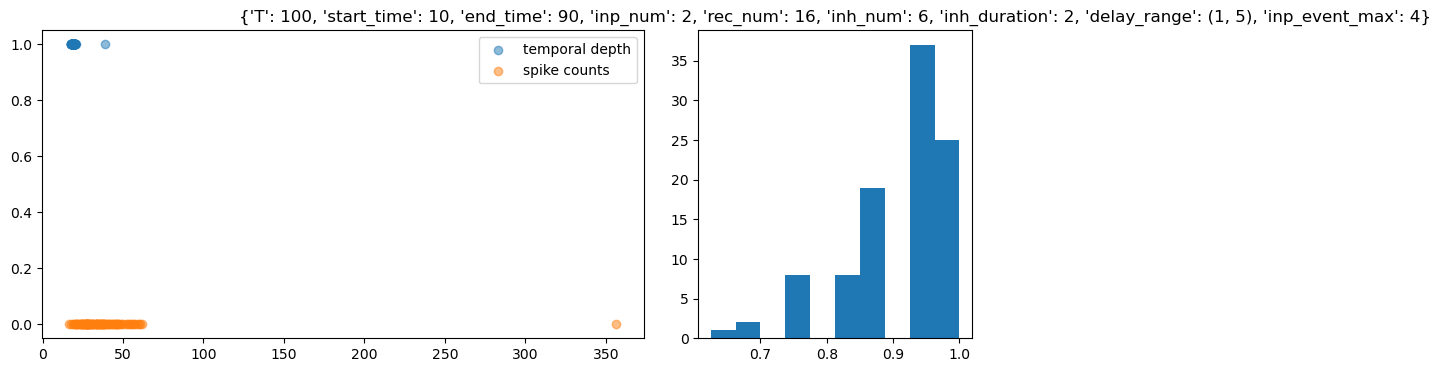

In [172]:
fig,ax = plt.subplot_mosaic('AAB',figsize=(12,4))
ax['A'].scatter(temporal_depth,1+np.zeros_like(temporal_depth),alpha=0.5,label="temporal depth")
ax['A'].scatter(spike_counts,np.zeros_like(spike_counts),alpha=0.5,label="spike counts")
ax['A'].legend()
ax['B'].hist(unique_signatures)
print(np.mean(unique_signatures))
plt.title(params)
plt.show()

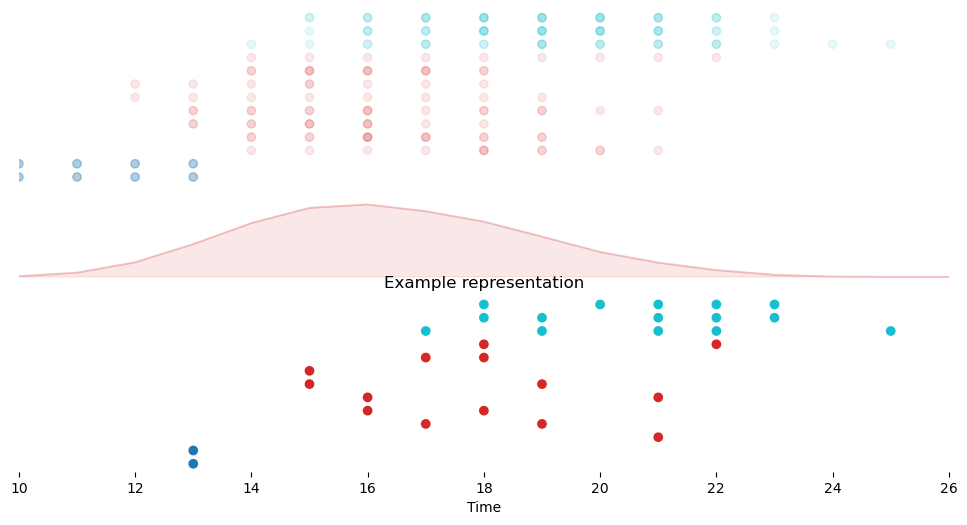

In [981]:
%matplotlib inline
fig,ax = plt.subplot_mosaic('A;A;B;C;C',figsize=(12,6))

trial = 0


for events in all_events:
    ax['A'].scatter(*np.where(events),c=colors[np.where(events)[1]],alpha=0.1)


x = np.arange(0,len(np.sum(all_rec_events,axis=(0,2))))
y=gaussian_filter1d(np.sum(all_rec_events,axis=(0,2)),1)
ax['B'].fill_between(x,y ,color='#d62728',alpha=0.1)
ax['B'].plot(x,y ,color='#d62728',alpha=0.2)
    
ax['C'].scatter(*np.where(all_events[example,...]),c=colors[np.where(all_events[example,...])[1]],alpha=1)

ax['A'].set_yticklabels([])
ax['B'].set_yticklabels([])
ax['C'].set_yticklabels([])

ax['A'].set_yticks([])
ax['B'].set_yticks([])

ax['C'].set_yticks([])

ax['A'].set_xticks([])
ax['B'].set_xticks([])



# ax['A'].set_xticklabels()
ax['B'].set_xticklabels([])
# ax['C'].set_xticklabels([])
ax['C'].set_xlabel('Time')
ax['C'].set_title('Example representation')

[ax[k].set_xlim(start_time,np.max(temporal_depth+inp_event_max)) for k in ax]
spines = ["top","right","left","bottom"]
for s in spines:
    [ax[k].spines[s].set_visible(False) for k in ax]


plt.show()

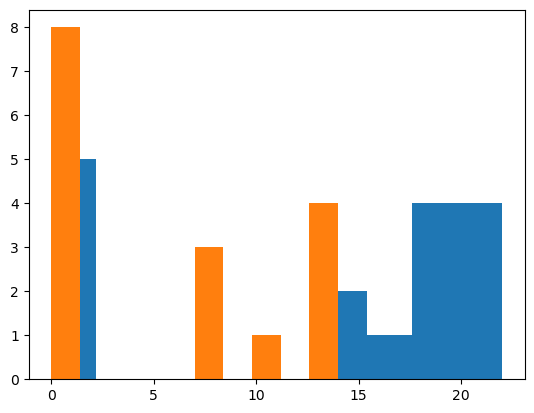

In [924]:
plt.figure()
plt.hist(temporal_depth)
plt.hist(evoked_spikes_num)
plt.show()

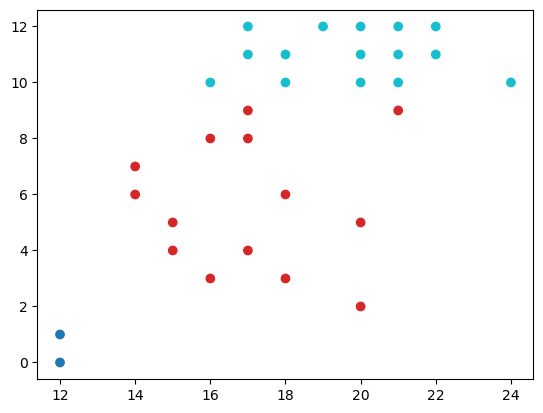

In [763]:
i=10
plt.figure()
plt.scatter(*np.where(all_events[i,...]),c=colors[np.where(all_events[i,...])[1]],alpha=1)
plt.show()

This could turn into a linear regression problem? Try to minimize the total number of response spikes (including the inhibitory neuron number) while maximizing the structural differences in spatio-temporal motifs.